In [1]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import scipy.signal as signal
import os
import pickle

In [2]:
def normCrossCor(x, y):
    # Convert to numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Zero-mean and normalize (important!)
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)

    # Full cross-correlation
    corr = signal.correlate(x, y, mode='full')

    # Normalize by length
    corr /= len(x)

    # Compute lag array
    # Lags range from -(len(x)-1) to +(len(y)-1)
    lags = np.arange(-len(x)+1, len(y))

    return lags, corr

In [3]:
filepath= './dataFolder/TrackingData_2022_11_10/thresholded_bodyparts/MV_fixed/'
trackPoints_files = glob.glob(filepath + '*bodyparts.csv')

filepath_another = './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed/'
pilifer_signal_files = glob.glob(filepath_another + '*errorAngle.csv')

In [6]:
pilifer_signal_files

['./dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m11_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m13_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m14_130806_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m1_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m4_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m5_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m8_130805_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m9_130801_errorAngle.csv']

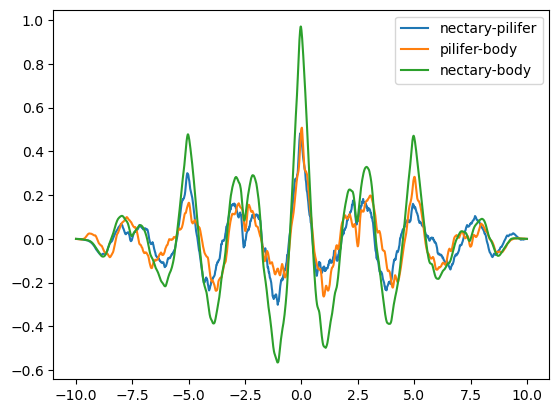

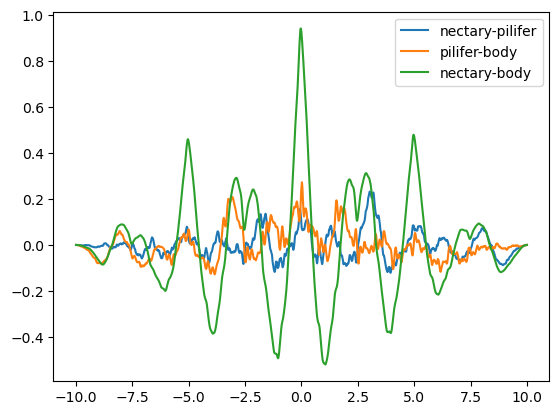

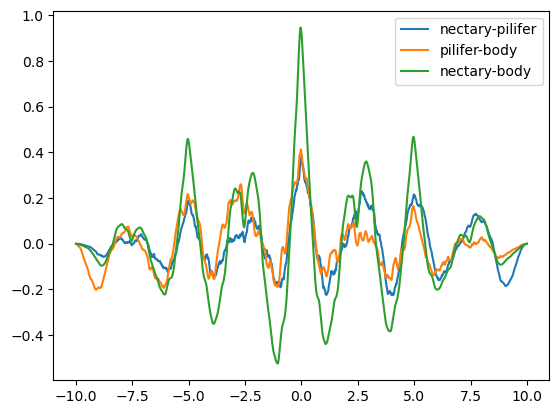

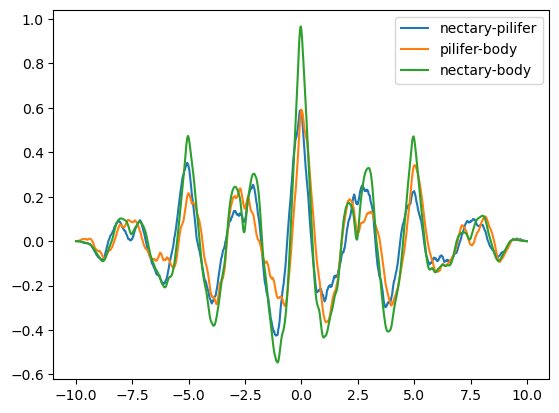

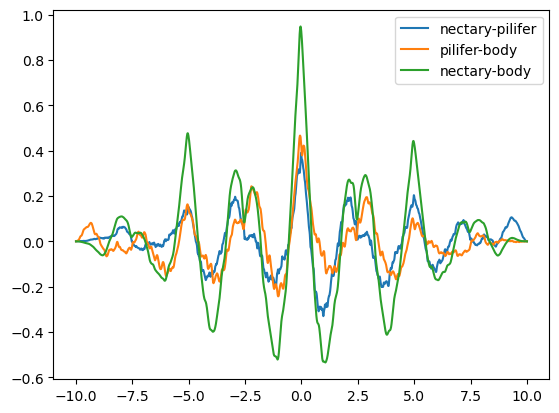

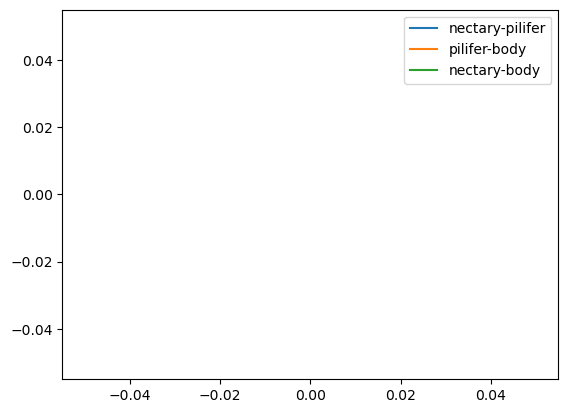

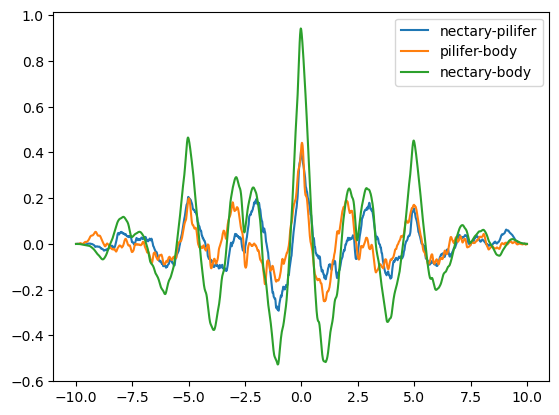

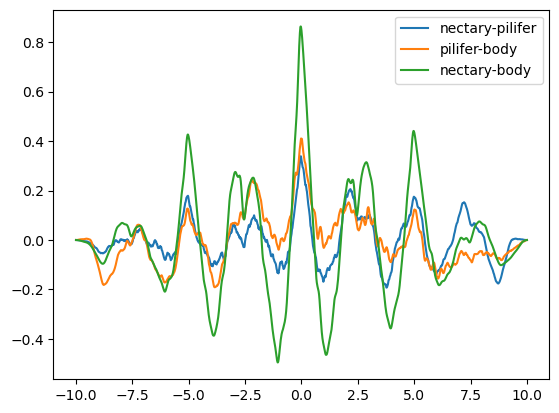

In [7]:
fig_directory_name = './dataFolder/TrackingData_2022_11_10/ErrorAngle/Plots/CrossCorrelation/'
output_directory = './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor/'

freq = 100
dt = 1/freq

for f in pilifer_signal_files:
    pilifer_signal = pd.read_csv(f, index_col=0)
    mothID = f.split('\\')[-1][:-15]
    
    trackPoints = pd.read_csv([file for file in trackPoints_files if mothID in file][0], index_col=0)
    
    pilifer_signal_smooth = signal.savgol_filter(pilifer_signal.values.flatten(), 5, 3)
    pilifer_signal_smooth_deg = pilifer_signal_smooth*(180/np.pi)
    
    body_lateral = trackPoints.loc[:,'body_x']
    nectary_lateral = trackPoints.loc[:,'nectary_x']
    
    lags = signal.correlation_lags(len(nectary_lateral), len(pilifer_signal_smooth_deg))
    
    lags, xcorr_nect_pilifer = normCrossCor(nectary_lateral, pilifer_signal_smooth_deg)
    lags_1, xcorr_pilifer_body = normCrossCor(pilifer_signal_smooth_deg, body_lateral)
    lags_2, xcorr_nect_body = normCrossCor(nectary_lateral, body_lateral)
    
    # Store in a dictionary (recommended for easier retrieval)
    data_dict = {
        'timedelay': lags,
        'nectary_pilifer_xcorr': xcorr_nect_pilifer,
        'pilifer_body_xcorr': xcorr_pilifer_body,
        'nectary_body_xcorr': xcorr_nect_body
    }

    # Define the filename for the pickle file
    filename = 'CrossCor_' + mothID + '.pkl'
    full_path = os.path.join(output_directory, filename)

    # Dump the data to the pickle file
    # Using the dictionary for demonstration
    with open(full_path, 'wb') as pickle_f:
        pickle.dump(data_dict, pickle_f)
    
    f = plt.figure()
    plt.plot(lags*dt, xcorr_nect_pilifer, label = 'nectary-pilifer')
    plt.plot(lags_1*dt, xcorr_pilifer_body, label = 'pilifer-body')
    plt.plot(lags_2*dt, xcorr_nect_body, label = 'nectary-body')
    plt.legend()
    f.savefig(fig_directory_name + mothID + '_crosscor.png')

## get the extreme values and put it in a form of a plot

In [20]:
output_directory = './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor/'
files = glob.glob(output_directory + 'CrossCor*')

In [21]:
files

['./dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_MV_m11_130802.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_MV_m13_130802.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_MV_m14_130806.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_MV_m1_130802.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_MV_m4_130802.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_MV_m5_130802.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_MV_m8_130805.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_MV_m9_130801.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_M_m10_130715.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_M_m11_130715.pkl',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor\\CrossCor_M_m18_130711.pkl',
 './dataFolder/TrackingData_2

In [22]:
input_output = ['nectary-pilifer', 'pilifer-body', 'nectary-body']
variables = ['maxAtZero', 'max', 'delTatMax']

cols = pd.MultiIndex.from_product(
    [input_output, variables],
    names=['input_output', 'variables']
)

# Prepare an empty list to collect each ID's data row
rows = []
ids = []

for xcorr_file in files:
    try:
        with open(xcorr_file, 'rb') as f:
            loaded_data = pickle.load(f)
        
        mothID = xcorr_file.split('\\')[-1][9:-4]
        
        ts = loaded_data['timedelay']
        xcorr_nectary_pilifer = loaded_data['nectary_pilifer_xcorr']
        xcorr_pilifer_body = loaded_data['pilifer_body_xcorr']
        xcorr_nectary_body = loaded_data['nectary_body_xcorr']
        
    except Exception as e:
        print(f"An error occurred during loading: {e}")
        
    # get the max or minimum value of coherence
    nect_pilifer_max = xcorr_nectary_pilifer[np.argmax(abs(xcorr_nectary_pilifer))]
    pilifer_body_max = xcorr_pilifer_body[np.argmax(abs(xcorr_pilifer_body))]
    nect_body_max = xcorr_nectary_body[np.argmax(abs(xcorr_nectary_body))]
    
    # get the detT at which it was max
    nect_pilifer_delTmax = ts[np.argmax(abs(xcorr_nectary_pilifer))]
    pilifer_body_delTmax = ts[np.argmax(abs(xcorr_pilifer_body))]
    nect_body_delTmax = ts[np.argmax(abs(xcorr_nectary_body))]
    
#     # get value at T0
    zero_index = np.where(ts == 0)[0][0]
    nect_pilifer_atZero = xcorr_nectary_pilifer[zero_index]
    pilifer_body_atZero = xcorr_pilifer_body[zero_index]
    nect_body_atZero = xcorr_nectary_body[zero_index]
    
    data_row = [nect_pilifer_atZero, nect_pilifer_max, nect_pilifer_delTmax,
               pilifer_body_atZero, pilifer_body_max, pilifer_body_delTmax,
               nect_body_atZero, nect_body_max, nect_body_delTmax]
    
    # Store results
    rows.append(data_row)
    ids.append(mothID)

# Build the final DataFrame
df = pd.DataFrame(rows, index=ids, columns=cols)
df.to_csv('./dataFolder/TrackingData_2022_11_10/ErrorAngle/CrossCor/' + 'allmoths.csv')

In [23]:
df

input_output  nectary-pilifer                     pilifer-body            \
variables           maxAtZero       max delTatMax    maxAtZero       max   
MV_m11_130802        0.441696  0.482354        -6     0.504503  0.508294   
MV_m13_130802        0.086110  0.231991       303     0.250954  0.272410   
MV_m14_130806        0.364642  0.377714        -2     0.392951  0.412938   
MV_m1_130802         0.578445  0.588169        -6     0.588380  0.592127   
MV_m4_130802         0.372463  0.390183        -2     0.408774  0.466310   
MV_m5_130802              NaN       NaN      -999          NaN       NaN   
MV_m8_130805         0.389680  0.406061        -2     0.432952  0.441954   
MV_m9_130801         0.321745  0.338690        -3     0.409588  0.410602   
M_m10_130715         0.107852  0.256185       169     0.105836  0.262726   
M_m11_130715              NaN       NaN      -999          NaN       NaN   
M_m18_130711         0.010200 -0.249488       -68    -0.035968 -0.244585   
M_m19_130711        -0.390433 -0.439935        11    -0.431697 -0.582358   
M_m3_130715         -0.032808 -0.154012       167    -0.178356 -0.221062   
M_m6_130715         -0.114721  0.249893       137    -0.077455  0.242639   
M_m8_130715         -0.402435 -0.411287         3    -0.254873  0.380247   
M_m9_130715         -0.466873 -0.487991         5    -0.243204  0.490247   
V_m10_130719              NaN       NaN      -999          NaN       NaN   
V_m11_130722        -0.247146 -0.260865        -1     0.042198  0.348274   
V_m2_130720         -0.245966 -0.249636        -1     0.519703  0.521469   
V_m3_130719               NaN       NaN      -999          NaN       NaN   
V_m4_130722          0.078429 -0.258364      -123     0.619341  0.664037   
V_m5_130719               NaN       NaN      -999          NaN       NaN   
V_m6_130719          0.265518 -0.346406      -119     0.533965  0.550410   
V_m8_130719         -0.018355  0.176667       113    -0.011220  0.267582   
V_m9_130722         -0.047729  0.291039       103     0.263945  0.414323   

input_output            nectary-body                      
variables     delTatMax    maxAtZero       max delTatMax  
MV_m11_130802         2     0.953120  0.971213        -3  
MV_m13_130802         2     0.921068  0.941489        -3  
MV_m14_130806        -3     0.921071  0.946702        -4  
MV_m1_130802         -1     0.946052  0.966438        -3  
MV_m4_130802         -6     0.914286  0.947615        -4  
MV_m5_130802       -999          NaN       NaN      -999  
MV_m8_130805          2     0.927614  0.941749        -3  
MV_m9_130801         -2     0.847413  0.863562        -3  
M_m10_130715       -178     0.832570  0.883385        -6  
M_m11_130715       -999          NaN       NaN      -999  
M_m18_130711         57     0.803430  0.876691        -7  
M_m19_130711        -12     0.825303  0.857540        -4  
M_m3_130715        -172     0.866560  0.896585        -4  
M_m6_130715        -138     0.904647  0.945268        -5  
M_m8_130715          66     0.869963  0.927068        -6  
M_m9_130715          74     0.910046  0.942796        -4  
V_m10_130719       -999          NaN       NaN      -999  
V_m11_130722        318     0.096040  0.304881       -73  
V_m2_130720           1    -0.280502  0.381436      -374  
V_m3_130719        -999          NaN       NaN      -999  
V_m4_130722           6     0.093411 -0.274173      -120  
V_m5_130719        -999          NaN       NaN      -999  
V_m6_130719          21     0.530731  0.543969         7  
V_m8_130719         303     0.122673 -0.333116        65  
V_m9_130722          17    -0.153440  0.299601       -73